# Building an RNN for Machine Translation
## Initial Data Work

In this file we will read in the data for the Vietnamese and Chinese to Engish corpuses, build a token2id and char2id mapping, vocabularies and data loaders

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch import optim
import pickle as pkl
import random
import csv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

random.seed(123)

PAD_IDX = 0
UNK_IDX = 1
SOS_IDX = 2
EOS_IDX = 3
BATCH_SIZE = 64

## Loading in training, validation and test sets

In [2]:
#Loading in the Vietnamese -> En datasets

train_vi_en = []
with open('../project_data/en-vi/train.tok.en') as inputfile:
    for line in inputfile:
        train_vi_en.append(line.strip().lower().split(' '))

train_vi_vi = []
with open('../project_data/en-vi/train.tok.vi') as inputfile:
    for line in inputfile:
        train_vi_vi.append(line.strip().lower().split(' '))

val_vi_en = []
with open('../project_data/en-vi/dev.tok.en') as inputfile:
    for line in inputfile:
        val_vi_en.append(line.strip().lower().split(' '))

val_vi_vi = []
with open('../project_data/en-vi/dev.tok.vi') as inputfile:
    for line in inputfile:
        val_vi_vi.append(line.strip().lower().split(' '))
        
test_vi_en = []
with open('../project_data/en-vi/test.tok.en') as inputfile:
    for line in inputfile:
        test_vi_en.append(line.strip().lower().split(' '))

test_vi_vi = []
with open('../project_data/en-vi/test.tok.vi') as inputfile:
    for line in inputfile:
        test_vi_vi.append(line.strip().lower().split(' '))

In [3]:
#Loading in the Chinese -> En datasets

train_zh_en = []
with open('../project_data/en-zh/train.tok.en') as inputfile:
    for line in inputfile:
        train_zh_en.append(line.strip().lower().split(' '))

train_zh_zh = []
with open('../project_data/en-zh/train.tok.zh') as inputfile:
    for line in inputfile:
        train_zh_zh.append(line.strip().lower().split(' '))

val_zh_en = []
with open('../project_data/en-zh/dev.tok.en') as inputfile:
    for line in inputfile:
        val_zh_en.append(line.strip().lower().split(' '))

val_zh_zh = []
with open('../project_data/en-zh/dev.tok.zh') as inputfile:
    for line in inputfile:
        val_zh_zh.append(line.strip().lower().split(' '))
        
test_zh_en = []
with open('../project_data/en-zh/test.tok.en') as inputfile:
    for line in inputfile:
        test_zh_en.append(line.strip().lower().split(' '))

test_zh_zh = []
with open('../project_data/en-zh/test.tok.zh') as inputfile:
    for line in inputfile:
        test_zh_zh.append(line.strip().lower().split(' '))

In [4]:
#Sanity Checking
print("Vi -> En | Training Examples: "+str(len(train_vi_en)))
print("Vi -> En | Training Examples: "+str(len(train_vi_vi)), '\n')

print("Vi -> En | Validation Examples: "+str(len(val_vi_en)))
print("Vi -> En | Validation Examples: "+str(len(val_vi_vi)), '\n')

print("Vi -> En | Testing Examples: "+str(len(test_vi_en)))
print("Vi -> En | Testing Examples: "+str(len(test_vi_vi)), '\n')

print("Zh -> En | Training Examples: "+str(len(train_zh_en)))
print("Zh -> En | Training Examples: "+str(len(train_zh_zh)), '\n')

print("Zh -> En | Validation Examples: "+str(len(val_zh_en)))
print("Zh -> En | Validation Examples: "+str(len(val_zh_zh)), '\n')

print("Zh -> En | Testing Examples: "+str(len(test_zh_en)))
print("Zh -> En | Testing Examples: "+str(len(test_zh_zh)), '\n')

Vi -> En | Training Examples: 133317
Vi -> En | Training Examples: 133317 

Vi -> En | Validation Examples: 1268
Vi -> En | Validation Examples: 1268 

Vi -> En | Testing Examples: 1553
Vi -> En | Testing Examples: 1553 

Zh -> En | Training Examples: 213377
Zh -> En | Training Examples: 213377 

Zh -> En | Validation Examples: 1261
Zh -> En | Validation Examples: 1261 

Zh -> En | Testing Examples: 1397
Zh -> En | Testing Examples: 1397 



## Building vocab and id2token

In [5]:
from collections import Counter

def build_vocab(all_tokens, vocab_size):
    token_counter = Counter(all_tokens)
    vocab, count = zip(*token_counter.most_common(vocab_size))
    id2token = list(vocab)
    token2id = dict(zip(vocab, range(4,4+len(vocab)))) 
    id2token = ['<pad>', '<unk>', '<sos>', '<eos>'] + id2token
    token2id['<pad>'] = PAD_IDX 
    token2id['<unk>'] = UNK_IDX
    token2id['<sos>'] = SOS_IDX
    token2id['<eos>'] = EOS_IDX
    return token2id, id2token

In [6]:
en_train_tokens = [item for sublist in train_vi_en for item in sublist]
en_train_tokens = en_train_tokens + [item for sublist in train_zh_en for item in sublist]
vi_train_tokens = [item for sublist in train_vi_vi for item in sublist]
zh_train_tokens = [item for sublist in train_zh_zh for item in sublist]

In [7]:
#Using vocab size up to equal our pre-trained embeddings so we have comparable results
en_token2id, en_id2token = build_vocab(en_train_tokens, 2519370)
vi_token2id, vi_id2token = build_vocab(vi_train_tokens, 292168)
zh_token2id, zh_id2token = build_vocab(zh_train_tokens, 332647)

### Encoding our data

In [8]:
VI_EN_MAX_LENGTH = int(np.percentile([len(sentence) for sentence in train_vi_en+train_vi_vi], 90))+1
ZH_EN_MAX_LENGTH = int(np.percentile([len(sentence) for sentence in train_zh_en+train_zh_zh], 90))+1

In [9]:
def encoding_tokens(sentence, language, translator):
    if language== 'English':
        token2id = en_token2id
    elif language== 'Vietnamese':
        token2id = vi_token2id
    elif language== 'Chinese':
        token2id = zh_token2id
    tokens = [token2id[token] if token in token2id else UNK_IDX for token in sentence]
    if translator == 'vi':
        max_len = VI_EN_MAX_LENGTH-1
    elif translator == 'zh':
        max_len = ZH_EN_MAX_LENGTH-1
    tokens=tokens[:max_len]
    return tokens

def encoding_dataset(dataset, language, translator):
    data = [encoding_tokens(tokens, language, translator) for tokens in dataset] 
    return data

In [10]:
train_vi_en = encoding_dataset(train_vi_en, 'English', 'vi')
train_vi_vi = encoding_dataset(train_vi_vi, 'Vietnamese', 'vi')
test_vi_en = encoding_dataset(test_vi_en, 'English', 'vi')
test_vi_vi = encoding_dataset(test_vi_vi, 'Vietnamese', 'vi')
val_vi_en = encoding_dataset(val_vi_en, 'English', 'vi')
val_vi_vi = encoding_dataset(val_vi_vi, 'Vietnamese', 'vi')

train_zh_en = encoding_dataset(train_zh_en, 'English', 'zh')
train_zh_zh = encoding_dataset(train_zh_zh, 'Chinese', 'zh')
test_zh_en = encoding_dataset(test_zh_en, 'English', 'zh')
test_zh_zh = encoding_dataset(test_zh_zh, 'Chinese', 'zh')
val_zh_en = encoding_dataset(val_zh_en, 'English', 'zh')
val_zh_zh = encoding_dataset(val_zh_zh, 'Chinese', 'zh')

## Building Data Loaders

In [11]:
class translationDataset(Dataset):
    def __init__(self, data_list, target_list):
        self.data_list=data_list
        self.target_list=target_list
        assert (len(self.data_list) == len(self.target_list))

    def __len__(self):
        return len(self.target_list)

    def __getitem__(self, key):
        data = self.data_list[key][:MAX_SAMPLE_LENGTH]
        label = self.target_list[key][:MAX_SAMPLE_LENGTH]
        return [data, len(data), label, len(label)]

def translation_collate_func(batch):
    data_list = []
    label_list = []
    for datum in batch:
        padded_data = np.pad(np.array(datum[0]+[EOS_IDX]), 
                                pad_width=((0,MAX_SAMPLE_LENGTH-datum[1])), 
                                mode="constant", constant_values=0)
        data_list.append(padded_data)
        padded_label = np.pad(np.array(datum[2]+[EOS_IDX]), 
                                pad_width=((0,MAX_SAMPLE_LENGTH-datum[3])), 
                                mode="constant", constant_values=0)
        label_list.append(padded_label)
    return [torch.from_numpy(np.array(data_list)), torch.from_numpy(np.array(label_list))]

In [12]:
# VI -> EN | dataloaders
MAX_SAMPLE_LENGTH = VI_EN_MAX_LENGTH

vi_en_train_dataset = translationDataset(train_vi_vi, train_vi_en)
vi_en_train_loader = torch.utils.data.DataLoader(dataset=vi_en_train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=translation_collate_func,
                                           shuffle=True)

vi_en_val_dataset = translationDataset(val_vi_vi, val_vi_en)
vi_en_val_loader = torch.utils.data.DataLoader(dataset=vi_en_val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=translation_collate_func,
                                           shuffle=True)

vi_en_test_dataset = translationDataset(test_vi_vi, test_vi_en)
vi_en_test_loader = torch.utils.data.DataLoader(dataset=vi_en_test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=translation_collate_func,
                                           shuffle=True)

In [13]:
# ZH -> EN | dataloaders
MAX_SAMPLE_LENGTH = ZH_EN_MAX_LENGTH

zh_en_train_dataset = translationDataset(train_zh_zh, train_zh_en)
zh_en_train_loader = torch.utils.data.DataLoader(dataset=zh_en_train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=translation_collate_func,
                                           shuffle=True)

zh_en_val_dataset = translationDataset(val_zh_zh, val_zh_en)
zh_en_val_loader = torch.utils.data.DataLoader(dataset=zh_en_val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=translation_collate_func,
                                           shuffle=True)

zh_en_test_dataset = translationDataset(test_zh_zh, test_zh_en)
zh_en_test_loader = torch.utils.data.DataLoader(dataset=zh_en_test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=translation_collate_func,
                                           shuffle=True)

## Building the RNN model

In [14]:
class EncoderRNN(nn.Module):
    def __init__(self, hidden_size, embedding_size, language, drop_rate=0):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.language = language
        if language == 'Vietnamese':
            self.embedding = nn.Embedding(len(vi_token2id), embedding_size)
        elif language == 'Chinese':
            self.embedding = nn.Embedding(len(zh_token2id), embedding_size)
        self.gru = nn.GRU(embedding_size, hidden_size)
        self.dropout = nn.Dropout(drop_rate)

    def forward(self, input):
        embedded = self.embedding(input)
        output = self.dropout(embedded)
        output, hidden = self.gru(output)
        return output, hidden

In [15]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, embedding_size, drop_rate=0):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(len(en_token2id), embedding_size)
        self.gru = nn.GRU(hidden_size + embedding_size, hidden_size)
        self.out = nn.Linear(hidden_size, len(en_token2id))
        self.softmax = nn.LogSoftmax(dim=1)
        self.dropout = nn.Dropout(p=drop_rate)

    def forward(self, input, hidden, enc_output):
        input.unsqueeze(0)
        embedded = self.dropout(self.embedding(input)).unsqueeze(0)
        embedded_concat = torch.cat((embedded, enc_output), dim=2)
        output, hidden = self.gru(embedded_concat, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

In [16]:
def showPlot(points, string):
    plt.figure()
    fig, ax = plt.subplots()
    plt.plot(points)
    plt.title(string)
    plt.savefig((string+'.png'), dpi=300)

In [17]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [18]:
teacher_forcing_ratio = 0.5

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion):
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    input_tensor = input_tensor.transpose(0,1)
    target_tensor = target_tensor.transpose(0,1)
    
    max_length = input_tensor.size(0)
    batch_size = input_tensor.size(1)
    vocab_size = len(en_token2id)
    
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size)

    loss = 0
    
    encoder_output, encoder_hidden = encoder(
        input_tensor)
    encoder_outputs = encoder_output[0,0]

    #decoder_input = torch.tensor([[SOS_IDX]])
    decoder_input = input_tensor[0,:]
    decoder_hidden = encoder_hidden
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    
    if use_teacher_forcing:
        for di in range(max_length):
            decoder_output, decoder_hidden = decoder(
               decoder_input, decoder_hidden, encoder_hidden)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]
    else:
        for di in range(max_length):
            decoder_output, decoder_hidden = decoder(
               decoder_input, decoder_hidden, encoder_hidden)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()
            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input[di].item() == EOS_IDX:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / max_length

In [22]:
def trainIters(loader, encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    language = encoder.language
    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()
    
    for iter in range(1, n_iters + 1):
        for i, (data, labels) in enumerate(loader):
            input_tensor = data
            target_tensor = labels
    
            loss = train(input_tensor, target_tensor, encoder,
                         decoder, encoder_optimizer, decoder_optimizer, criterion)
            print_loss_total += loss
            plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
    showPlot(plot_losses, language)
    return plot_losses

In [23]:
#Training Model
hidden_size = 256
encoder1 = EncoderRNN(hidden_size, 300, 'Vietnamese', drop_rate=0.1)
decoder1 = DecoderRNN(hidden_size, 300, drop_rate=0.1)

In [ ]:
plot_losses = trainIters(vi_en_val_loader, encoder1, decoder1, n_iters=6, print_every=1, plot_every=1)

4m 5s (- 20m 25s) (1 16%) 2661.8217
8m 57s (- 17m 54s) (2 33%) 2879.4308
14m 23s (- 14m 23s) (3 50%) 1486.9293
18m 26s (- 9m 13s) (4 66%) 1201.4972
23m 18s (- 4m 39s) (5 83%) 1380.7139
27m 31s (- 0m 0s) (6 100%) 1516.5161
4m 43s (- 23m 36s) (1 16%) 391.6058
10m 10s (- 20m 20s) (2 33%) 265.6386
19m 6s (- 19m 6s) (3 50%) 270.4116
26m 42s (- 13m 21s) (4 66%) 287.9412
31m 1s (- 6m 12s) (5 83%) 292.9064
36m 59s (- 0m 0s) (6 100%) 216.2937
4m 7s (- 20m 38s) (1 16%) 186.7073
8m 38s (- 17m 17s) (2 33%) 244.8393
975m 44s (- 975m 44s) (3 50%) 220.2160
979m 36s (- 489m 48s) (4 66%) 193.0854
983m 51s (- 196m 46s) (5 83%) 219.5976
987m 36s (- 0m 0s) (6 100%) 250.3835


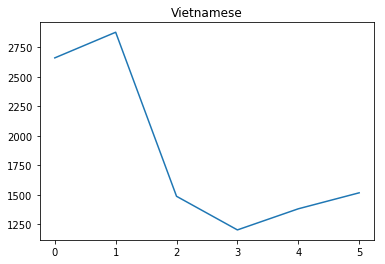

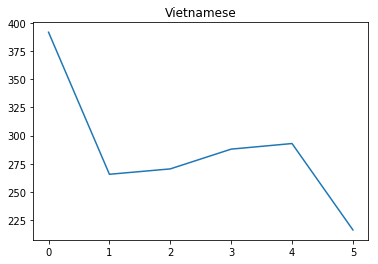

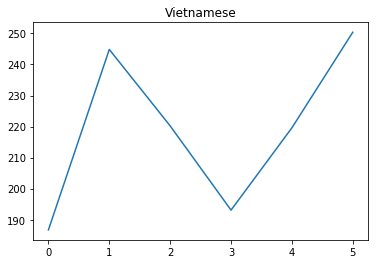

In [24]:
learning_rates = [0.1, 0.01, 0.001]
learning_rate_data = pd.DataFrame()

for lr in learning_rates:
    plot_losses = trainIters(vi_en_val_loader, encoder1, decoder1, learning_rate=lr, n_iters=6, print_every=1, plot_every=1)
    learning_rate_data[str(lr)] = pd.Series(plot_losses)

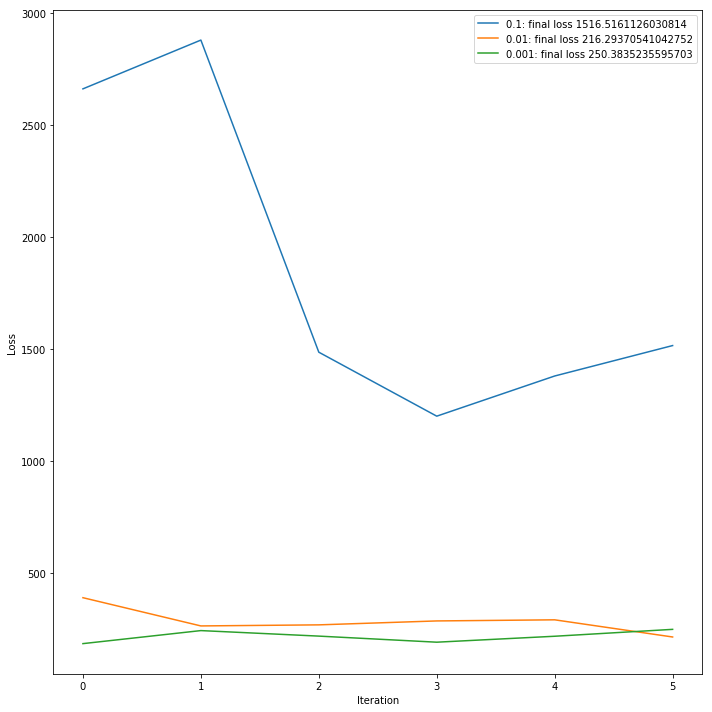

In [26]:
learning_rate_results = []
for i in range(3):
    value = list(learning_rate_data.iloc[-1])[i]
    value = str(learning_rates[i])+": final loss "+str(value)
    learning_rate_results.append(value)    
    
fig = plt.figure(figsize = (10,10))

plt.plot(learning_rate_data)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend(learning_rate_results, loc='best')
plt.tight_layout()
plt.savefig('leaning_rate_losses.png', dpi=300)
plt.show()

In [ ]:
drop_rates = [0, 0.3, 0.6]
drop_rate_data = pd.DataFrame()

for dr in drop_rates:
    encoder1 = EncoderRNN(hidden_size, 300, 'Vietnamese', drop_rate=dr)
    decoder1 = DecoderRNN(hidden_size, 300, drop_rate=dr)
    plot_losses = trainIters(vi_en_val_loader, encoder1, decoder1, learning_rate=0.01, n_iters=6, print_every=1, plot_every=1)
    drop_rate_data[str(dr)] = pd.Series(plot_losses)

In [ ]:
drop_rate_results = []
for i in range(3):
    value = list(drop_rate_data.iloc[-1])[i]
    value = str(drop_rates[i])+": final loss "+str(value)
    drop_rate_results.append(value)    
    
fig = plt.figure(figsize = (10,10))

plt.plot(drop_rate_data)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend(drop_rate_results, loc='best')
plt.tight_layout()
plt.savefig('drop_rate_losses.png', dpi=300)
plt.show()

In [ ]:
hidden_sizes = [128, 256]
hidden_size_data = pd.DataFrame()

for hs in hidden_sizes:
    encoder1 = EncoderRNN(hs, 300, 'Vietnamese', drop_rate=0.3)
    decoder1 = DecoderRNN(hs, 300, drop_rate=0.3)
    plot_losses = trainIters(vi_en_val_loader, encoder1, decoder1, learning_rate=0.01, n_iters=6, print_every=1, plot_every=1)
    hidden_size_data[str(hs)] = pd.Series(plot_losses)

In [ ]:
hidden_results = []
for i in range(3):
    value = list(hidden_size_data.iloc[-1])[i]
    value = str(hidden_sizes[i])+": final loss "+str(value)
    hidden_results.append(value)    
    
fig = plt.figure(figsize = (10,10))

plt.plot(hidden_size_data)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend(hidden_results, loc='best')
plt.tight_layout()
plt.savefig('hidden_results_losses.png', dpi=300)
plt.show()

In [ ]:
def evaluate(encoder, decoder, sentence, max_length):
    """
    Function that generate translation.
    First, feed the source sentence into the encoder and obtain the hidden states from encoder.
    Secondly, feed the hidden states into the decoder and unfold the outputs from the decoder.
    Lastly, for each outputs from the decoder, collect the corresponding words in the target language's vocabulary.
    And collect the attention for each output words.
    @param encoder: the encoder network
    @param decoder: the decoder network
    @param sentence: string, a sentence in source language to be translated
    @param max_length: the max # of words that the decoder can return
    @output decoded_words: a list of words in target language
    """    
    # process input sentence
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        # encode the source lanugage
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_IDX]])  # SOS
        # decode the context vector
        decoder_hidden = encoder_hidden # decoder starts from the last encoding sentence
        # output of this function
        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            # for each time step, the decoder network takes two inputs: previous outputs and the previous hidden states
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            
            # hint: print out decoder_output and decoder_attention
            # TODO: add your code here to populate decoded_words and decoder_attentions
            # TODO: do this in 2 ways discussed in class: greedy & beam_search
            
            # END TO DO
            
            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [ ]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

## Preparing the Data and Modeling

In [ ]:
def indexesFromSentence(lang, sentence):
    if lang = 'vi':
        return [vi_token2id[word] for word in sentence.split(' ')]
    elif lang = 'en':
        return [en_token2id[word] for word in sentence.split(' ')]
    elif lang = 'zh':
        return [zh_token2id[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_IDX)
    return torch.tensor(indexes, dtype=torch.long).view(-1, 1)